# Дискриминантный анализ неоднородных данных

## Цели

Имея классифицированную обучающую выборку с помощью дискриминантного анализа и других алгоритмов классифицировать многомерные неоднородные данные.

## Постановка задачи

Для данных Фишера:
1) Провести предварительный анализ кластерной структуры в данных;
2) Провести дискриминантный анализ данных;
3) При помощи других алгоритмов классификации с классифицироанной обучающей выборки классифицировать данные;
4) Провести сравнительный анализ полученных результатов.

*Указание*: использовать выборку из смеси распределений для всех переменных; для обучения и экзамена использовать выборки из различных классов в пропорциях 80% и 20%, либо процедуру кросс-валидации в тех же пропорциях; использовать алгоритмы: ЛДА, КДА, деревья решений CART и др.

## Введение

Будем пользоваться следующими методами: линейный параметрический дискриминантный анализ, квадратичный дискриминантный анализ, классификационные деревья решений, метод k ближайших соседей. Предварительно проведём исследование выборки на наличие кластерной
структуры (ожидается наличие трёх кластеров, согласно постановке задачи)

# Результаты исследований

## Подключение необходимых библиотек и загрузка данных

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, DecisionTreeClassifier


from scipy import stats
from scipy.stats import norm, skew, kurtosis, shapiro, chisquare, gaussian_kde, kstest, ttest_ind, spearmanr
from statistics import correlation
import statsmodels.api as sm

Выведем матрицу "объект-признак". В первых четырех столбцах находятся наши независимые переменные sepallen, sepalwid, petallen, petalwid, по которым мы будем проводить классификацию, 5-ом и 6-ом столбцах находятся метки классов для соответвутющих объектов, то есть зависимые переменные, которые мы будем предсказывать.

In [20]:
dataset = datasets.load_iris()

ext_target = dataset.target[:, None]
df = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'])
df = pd.concat([df.loc[df['target name'] == 'versicolor'], df.loc[df['target name'] == 'virginica']], axis=0)[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target label']].astype(float)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label
50,7.0,3.2,4.7,1.4,1.0
51,6.4,3.2,4.5,1.5,1.0
52,6.9,3.1,4.9,1.5,1.0
53,5.5,2.3,4.0,1.3,1.0
54,6.5,2.8,4.6,1.5,1.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


## Предварительный анализ

Случайную выборку образуют все 2 типа ириса: VERSICOLOR и VIRGINICA. Зависимой переменной будет являться метка класса target label, а независимыми - sepallen, sepalwid, petallen, petalwid. Рассмотрим матрицу диаграмм рассеяния, выделив кластеры разным цветом

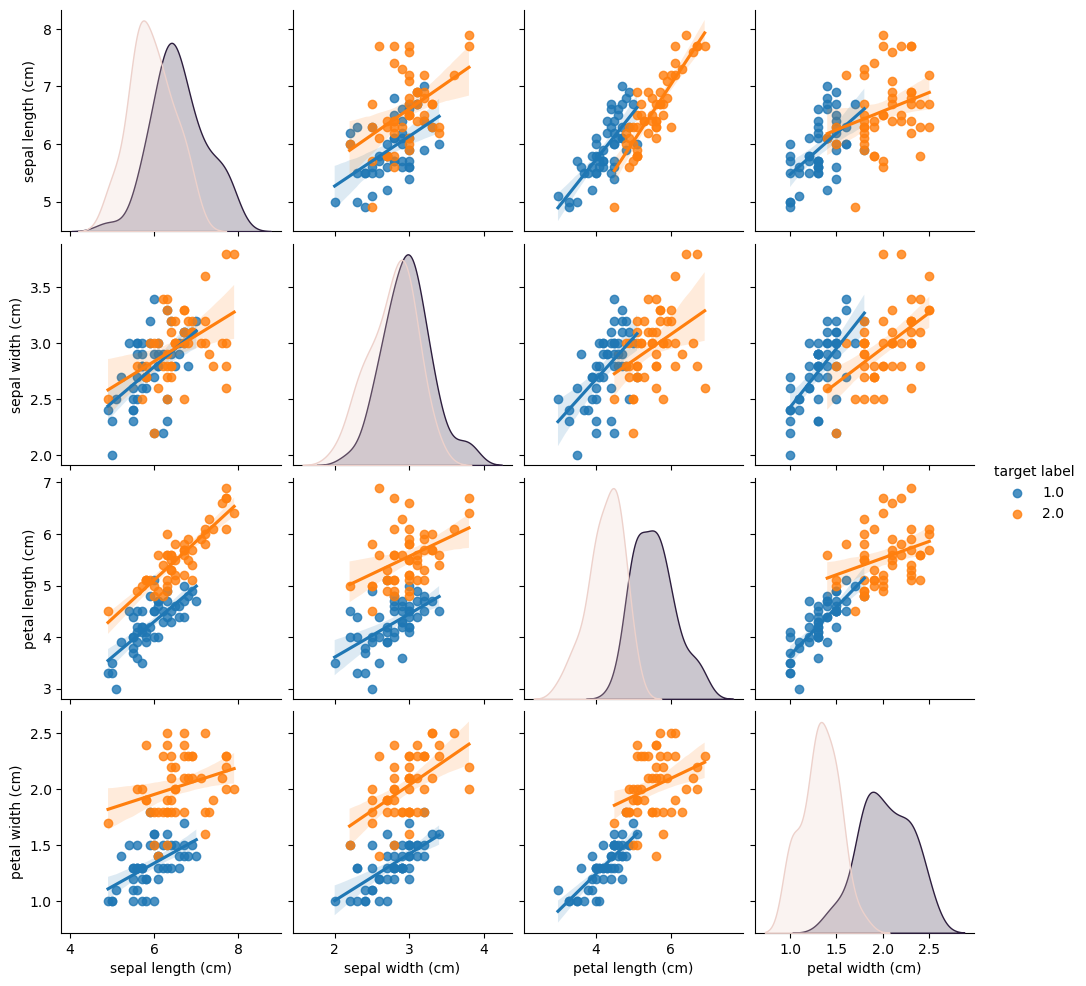

In [21]:
sns.pairplot(data=df, 
             kind='reg', diag_kind='auto', vars=df.columns[:-1], hue='target label')
None

Заметно, что кластеры virginica от versicolor могут быть отделимы по переменным petallen, petalwid лучше, чем по sepallen и sepalwid, где кластеры перемешаны.

Для дальнейшего исследования разобъем выборку на обучающую 80% и тестовую 20%.

In [33]:
X = df.iloc[:, :4]
y = df.iloc[:,4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Применение алгоритмов кластеризации в задаче обучения с классифицированной выборкой

### Линейный дискриминантный анализ

Создадим класс модели. Обучим ее на обучающей выборке и предскажем значения для тестовой выборки.

In [34]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Вычислим точность наших предсказаний (процент правильных предсказаний)

In [35]:
accuracy_score = sum(y_pred==y_test) / y_test.size
accuracy_score

0.8

Точность = 80% на тестовой выборке, то есть 80% значений из тестовой выборки мы предсказали верно. Проверим модель на кросс-валидации.

In [36]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.97


Средняя точность = 97%. Результат очень хороший, поэтому мы можем пытаться использовать этот алгоритм в реальной задаче.

Далее проделаем аналогичные действия для остальных моделей.

### Квадратичный дискриминантный анализ

In [44]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Вычислим точность.

In [45]:
accuracy_score = sum(y_pred==y_test) / y_test.size
accuracy_score

0.8

Точность оказалась одинаковой с моделью линейного дискриминантного анализа. Также проверим модель на кросс-валидации.

In [46]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.97


Таким образом, мы получили идентичные результаты при линейном и квадратичном дискриминантном анализе. Причем предсказания моделей имеют достаточно высокую точность. Таким образом, обе модели являются эффективными для решения задачи кластеризации с классифицированной обучающей выборкой.

### Метод k ближайших соседей

Возьмем метод k ближайших соседей с параметром $k\in [2, 20]$ и посмотрим, при каком значении параметра $k$ мы будем иметь наибольшую точность.

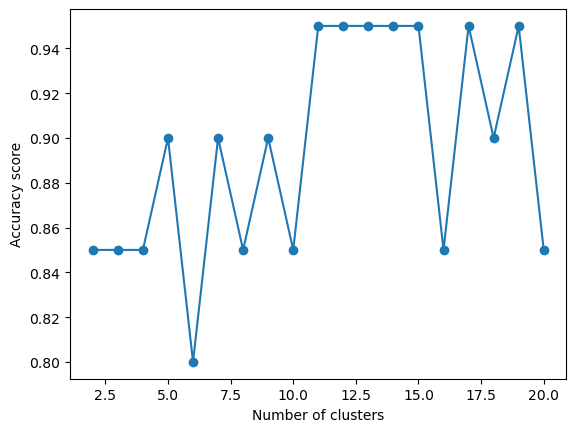

In [86]:
score = []

for i in range(2,21):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score.append(sum(y_pred==y_test) / y_test.size)

plt.plot(range(2,21), score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy score')
plt.show()

Наибольшая точность достигается при $k = \{11,12,13,14,15,17,19\}$. Возьмем наименьшее среди этих значений и подставим в модель.

In [87]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Вычислим точность.

In [88]:
accuracy_score = sum(y_pred==y_test) / y_test.size
accuracy_score

0.95

Точность на тренировочной выборке оказалась выше, чем у предыдущих алгоритмов. Посмотрим среднюю точность на кросс-валидации.

In [89]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.97


Средняя точность при кросс валидации оказалась аналогичной предыдущим алгоритмам. Таким образом, на данном этапе мы имеем, что метод kNN показал себя лучше, чем дискриминантный анализ на тренировочной выборке. Поэтому предпочтение можно отдать ему.

### Дерево решений

Построим представление дерева решений в виде графа, взяв максимально возможную глубину дерева равную 7.

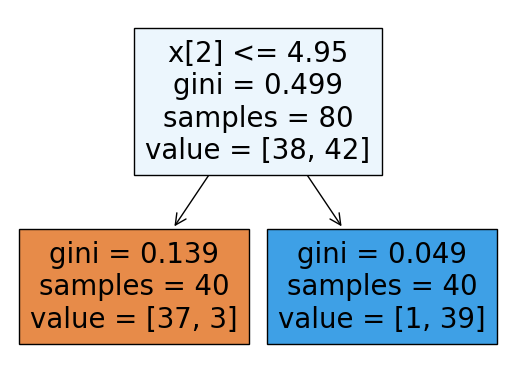

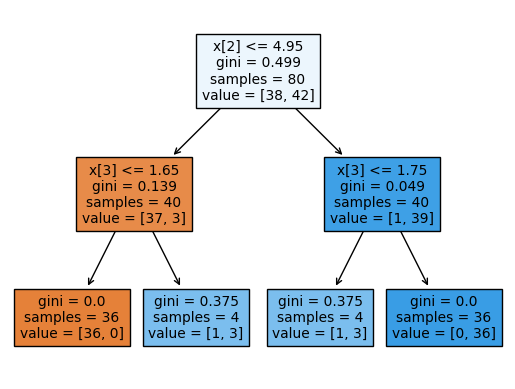

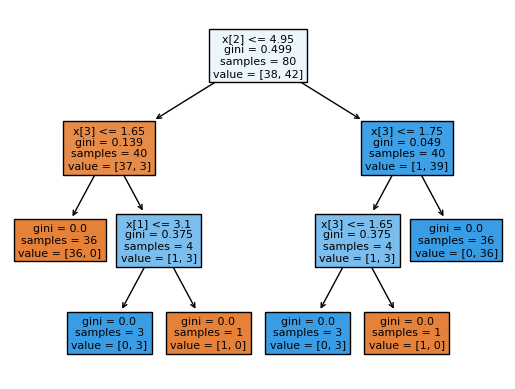

In [93]:
max_depth = 4
for depth in range(1, max_depth):
    plt.figure()
    clf = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    plot_tree(clf, filled=True)
    plt.show()

Дерево с глубиной 4 смогло достичь минимума целевой функции. Вычислим точность для этого дерева.

In [94]:
y_pred = clf.predict(X_test)
accuracy_score = sum(y_pred==y_test) / y_test.size
accuracy_score

0.95

Имеем все ту же точность, что и у kNN. Посмотрим среднюю точность на кросс валидации.

In [95]:
cv=cross_val_score(clf, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(cv))

0.95


На кросс валидации средняя точность оказалась ниже. Поэтому всё-таки лучше всего себя показала модель kNN. В завершение посмотрим, какой из признаков больше всего повлиял на принятие деревом "решений".

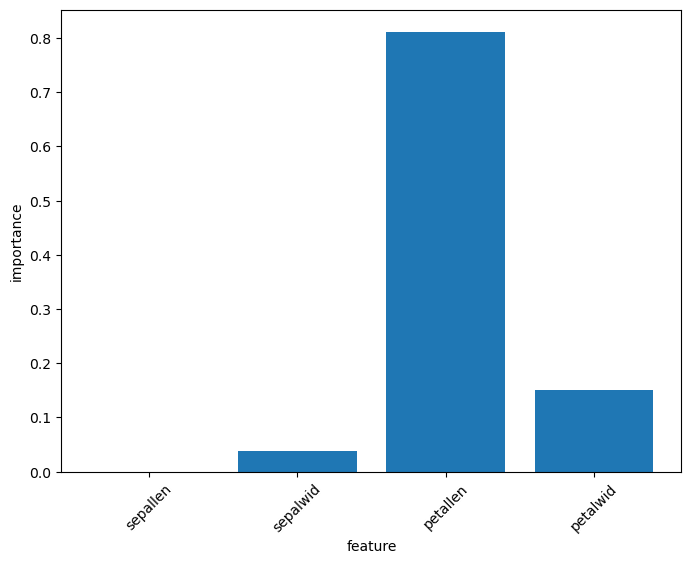

In [96]:
feature_importances = clf.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(range(X.shape[1]), feature_importances, align="center")
plt.xticks(range(X.shape[1]), ['sepallen', 'sepalwid', 'petallen', 'petalwid'], rotation=45)
plt.xlabel("feature")
plt.ylabel("importance")
plt.show()

Набольшее влияние оказал признак petallen. В свою очередь, sepallen оказался незначительным для модели.

# Вывод

Все рассмотренные выше алгоритмы справились с задачей классификации с достаточно высокой точностью. Лучше всего с задачей классификации справилась модель kNN, она показала наивысшую среди всех моделей точность как на тренировочной выборке, так и на обучающей выборке. Чуть хуже оказалась модель дерева решений глубины 4. На тренировочной выборке она имеет такую же точность, а на кросс валидации средняя точность оказалась ниже. Еще хуже себя показали модели дискриминантного анализа. 

Таким образом, при необходимости классификации нового вида ириса, которого нет в выборке, наилучшией моделью для классификации будет модель kNN.